Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [5]:
NAME = "" # put your full name here
COLLABORATORS = [] # list anyone you collaborated with on this workbook

## Lab 8: Model selection and regularization

Welcome to Lab 8!

In this lab, we'll cover model selection and regularization (ISLR 6.1-6.2). Before we get into that, let's review what we've done so far in terms of modeling:
* In Labs 5-6, we covered linear regression by using ordinary least-squares (OLS) optimization to find the intercept and slope coefficient for a a linear relationship.
* In Homework 6, we covered gradient descent, which is a way to find the coefficients of a model (in our case, a linear model) by iteratively calculating the coefficients using the gradient (the partial derivative of the model loss with respect to the coefficient) until we find a set of coefficients that minimize the loss function.
* In Lab 7, we covered cross-validation, which is a way to find out how well a model trained on certain data performs when tested on new data.

Model selection and regularization relate in some way to all of these topics. Model selection and regularization approaches give us a method to select which variables (i.e. features) to include in our model, as well as to select the value of the coefficients that should be associated with those variables. Cross-validation also allows us to select variables by providing a way to compare error across different models. 

Model selection and regularization are also related to OLS in that they provide different methods for choosing model coefficients. Rather than just minimizing the loss, techniques like Ridge or Lasso regression add a regularization term that penalizes the model if it includes too many features by pushing some of the coefficients to zero or close to zero.

Regularization methods like Ridge or Lasso can also work *with* cross-validation - for instance, in this lab, we're going to use cross-validation to tune the hyperparameter $\lambda$. We will use a random train-test split of the data to see how models with different values of $\lambda$ perform. Although we don't do it in this lab, a more systematic and rigorous way of evaluating different values of $\lambda$ would be to compare model performance using leave one out or k-fold cross validation.

In this lab, we'll focus on Ridge and Lasso regression, focusing on how to implement them and examining their prediction error and the coefficients that result from using these methods.

### Setup

In [6]:
# Run this block.
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

### Section 1: EDA and data filtering

We will be working with the Novotny et al. land-use regression dataset used in lecture during Week 6.  Here's a refresher about the data:

* The data includes GIS land-use characteristics from EPA land-monitoring and in situ NO2 measurements from satellite sensors.
* The goal of land-use regression (LUR) is to estimate outdoor air pollution geospatially across the contiguous United States.
* The reason for the high number of data points is that the data keeps track of readings from monitors at a high resolution, up to ~30 meters.

In [7]:
#run to load the dataset we'll be working with
df = pd.read_csv('data/BechleLUR_2006_allmodelbuildingdata.csv')

In [8]:
df.head()

,Monitor_ID,State,Latitude,Longitude,Observed_NO2_ppb,Predicted_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
0,04-013-0019-42602-1,AZ,33.48385,-112.14257,23.884706,20.986643,11.615223,313.0,0.304,59.4431,59.4715,59.4810,59.4572,59.3039,59.1636,59.0507,58.9488,58.7941,58.9821,59.2879,59.8456,60.1169,60.1553,59.7722,59.5908,59.5556,59.2200,58.3484,57.5475,56.3765,52.2642,3434.0000,3434.0000,3411.8328,3369.4805,3374.2180,3403.9201,3425.0499,3440.4236,3467.5636,3496.6767,3507.2187,3388.9482,3306.8511,3096.9563,2870.9081,2712.0688,2652.9409,2541.2515,2428.1611,2337.5601,2245.5723,2024.5460,0.00000,0.00000,0.00000,0.00000,0.49224,0.84872,1.11154,1.35858,3.48036,6.72288,10.45728,17.17240,21.46712,31.77685,50.76791,79.74268,104.89995,166.58362,231.04656,298.41773,384.37428,554.79507,0.61637,1.76406,3.64989,6.05967,9.08376,12.49667,16.72079,20.95306,28.19335,36.77423,56.07123,76.17936,92.75979,141.40171,208.14918,277.49442,360.92204,560.02672,803.90089,1089.93658,1404.00587,2083.12410,2269.08304,2454.55438,2635.14164,2843.33267,3069.31560,3254.15743,3433.87888,3623.34585,0.61637,1.76406,3.64989,6.05967,9.57600,13.34539,17.83233,22.31164,31.67371,43.49711,66.52851,93.35176,114.22691,173.17856,258.91709,357.23710,465.82199,726.61034,1034.94745,1388.35431,1788.38015,2637.91917,2862.73591,3096.99468,3339.22952,3609.20650,3896.25748,4150.54739,4396.96011,4651.18890
1,04-013-3002-42602-6,AZ,33.45793,-112.04601,25.089886,20.990096,11.472677,323.8,0.304,72.0000,72.0000,72.0000,72.0000,71.9109,71.6594,71.4787,71.4093,71.4899,71.6481,71.9319,71.8449,71.2728,69.4570,68.0373,66.6440,65.7764,63.4799,60.5909,59.0333,58.2535,55.1395,2715.9121,2820.9973,2857.7844,2882.9007,2922.6060,2955.1033,2980.2975,2975.5773,2858.6769,2713.3988,2540.6768,2411.3403,2336.4432,2171.0319,2067.0406,1998.7573,1939.4790,1826.4574,1728.7592,1683.7545,1683.8406,1652.0872,0.00000,0.16726,0.47770,0.70926,0.92816,3.44480,5.58398,7.46132,13.62402,26.06820,40.44928,51.82634,60.07474,79.14227,100.46330,130.76356,159.86952,232.42547,291.65556,383.84647,499.06352,705.01818,0.26126,1.14480,1.98903,4.33272,6.93099,9.68176,13.13134,17.11873,25.53028,36.59210,56.75135,83.25340,99.69127,149.45363,207.70180,272.08012,351.49761,549.40811,725.27587,947.93127,1231.98435,1857.31130,2029.32556,2196.75975,2384.41496,2579.46411,277

**Question 1.1 (1pt)** We create a dataframe `df_model` that contains only the response and predictor variables (i.e. you should drop Monitor_ID, State, Latitude, Longitude, and Predicted_NO2_ppb). The response variable is the observed NO2 concentration. 

Reminder: the target variable will allow us to estimate surface-level $NO_2$ levels at different points in space.

Why do we drop the columns [Monitor_ID, State, Latitude, Longitude, and Predicted_NO2_ppb]?

In [9]:
df_model = df.drop(columns = ['Monitor_ID', 'State', 'Latitude', 'Longitude', 'Predicted_NO2_ppb'])
df_model.head()

,Observed_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
0,23.884706,11.615223,313.0,0.304,59.4431,59.4715,59.4810,59.4572,59.3039,59.1636,59.0507,58.9488,58.7941,58.9821,59.2879,59.8456,60.1169,60.1553,59.7722,59.5908,59.5556,59.2200,58.3484,57.5475,56.3765,52.2642,3434.0000,3434.0000,3411.8328,3369.4805,3374.2180,3403.9201,3425.0499,3440.4236,3467.5636,3496.6767,3507.2187,3388.9482,3306.8511,3096.9563,2870.9081,2712.0688,2652.9409,2541.2515,2428.1611,2337.5601,2245.5723,2024.5460,0.00000,0.00000,0.00000,0.00000,0.49224,0.84872,1.11154,1.35858,3.48036,6.72288,10.45728,17.17240,21.46712,31.77685,50.76791,79.74268,104.89995,166.58362,231.04656,298.41773,384.37428,554.79507,0.61637,1.76406,3.64989,6.05967,9.08376,12.49667,16.72079,20.95306,28.19335,36.77423,56.07123,76.17936,92.75979,141.40171,208.14918,277.49442,360.92204,560.02672,803.90089,1089.93658,1404.00587,2083.12410,2269.08304,2454.55438,2635.14164,2843.33267,3069.31560,3254.15743,3433.87888,3623.34585,0.61637,1.76406,3.64989,6.05967,9.57600,13.34539,17.83233,22.31164,31.67371,43.49711,66.52851,93.35176,114.22691,173.17856,258.91709,357.23710,465.82199,726.61034,1034.94745,1388.35431,1788.38015,2637.91917,2862.73591,3096.99468,3339.22952,3609.20650,3896.25748,4150.54739,4396.96011,4651.18890
1,25.089886,11.472677,323.8,0.304,72.0000,72.0000,72.0000,72.0000,71.9109,71.6594,71.4787,71.4093,71.4899,71.6481,71.9319,71.8449,71.2728,69.4570,68.0373,66.6440,65.7764,63.4799,60.5909,59.0333,58.2535,55.1395,2715.9121,2820.9973,2857.7844,2882.9007,2922.6060,2955.1033,2980.2975,2975.5773,2858.6769,2713.3988,2540.6768,2411.3403,2336.4432,2171.0319,2067.0406,1998.7573,1939.4790,1826.4574,1728.7592,1683.7545,1683.8406,1652.0872,0.00000,0.16726,0.47770,0.70926,0.92816,3.44480,5.58398,7.46132,13.62402,26.06820,40.44928,51.82634,60.07474,79.14227,100.46330,130.76356,159.86952,232.42547,291.65556,383.84647,499.06352,705.01818,0.26126,1.14480,1.98903,4.33272,6.93099,9.68176,13.13134,17.11873,25.53028,36.59210,56.75135,83.25340,99.69127,149.45363,207.70180,272.08012,351.49761,549.40811,725.27587,947.93127,1231.98435,1857.31130,2029.32556,2196.75975,2384.41496,2579.46411,2771.68495,2968.16660,3152.91688,3364.20733,0.26126,1.31206,2.46673,5.04198,7.85915,13.12656,18.71532,24.58005,39.15430,62.66030,97.20063,135.07974,159.76601,228.5

YOUR ANSWER HERE

*SOLUTION* These are not independent variables that we want to use to build the model, they are descriptors of our observations granularity.

**Question 1.2 (3pts)** We have a lot of potential features in our dataset, and it's hard to visualize all of them in relation to our response variable. To gain some familiarity with the data, however, let's take a close look at a few. We have created a plot with 4 subplots below, and generated 4 scatterplots, each showing a different feature on the x-axis and the response variable on the y-axis. Do you observe any trends or relationships? Visually, would you expect a model selection algorithm to prioritize or minimize any of these features? Why?

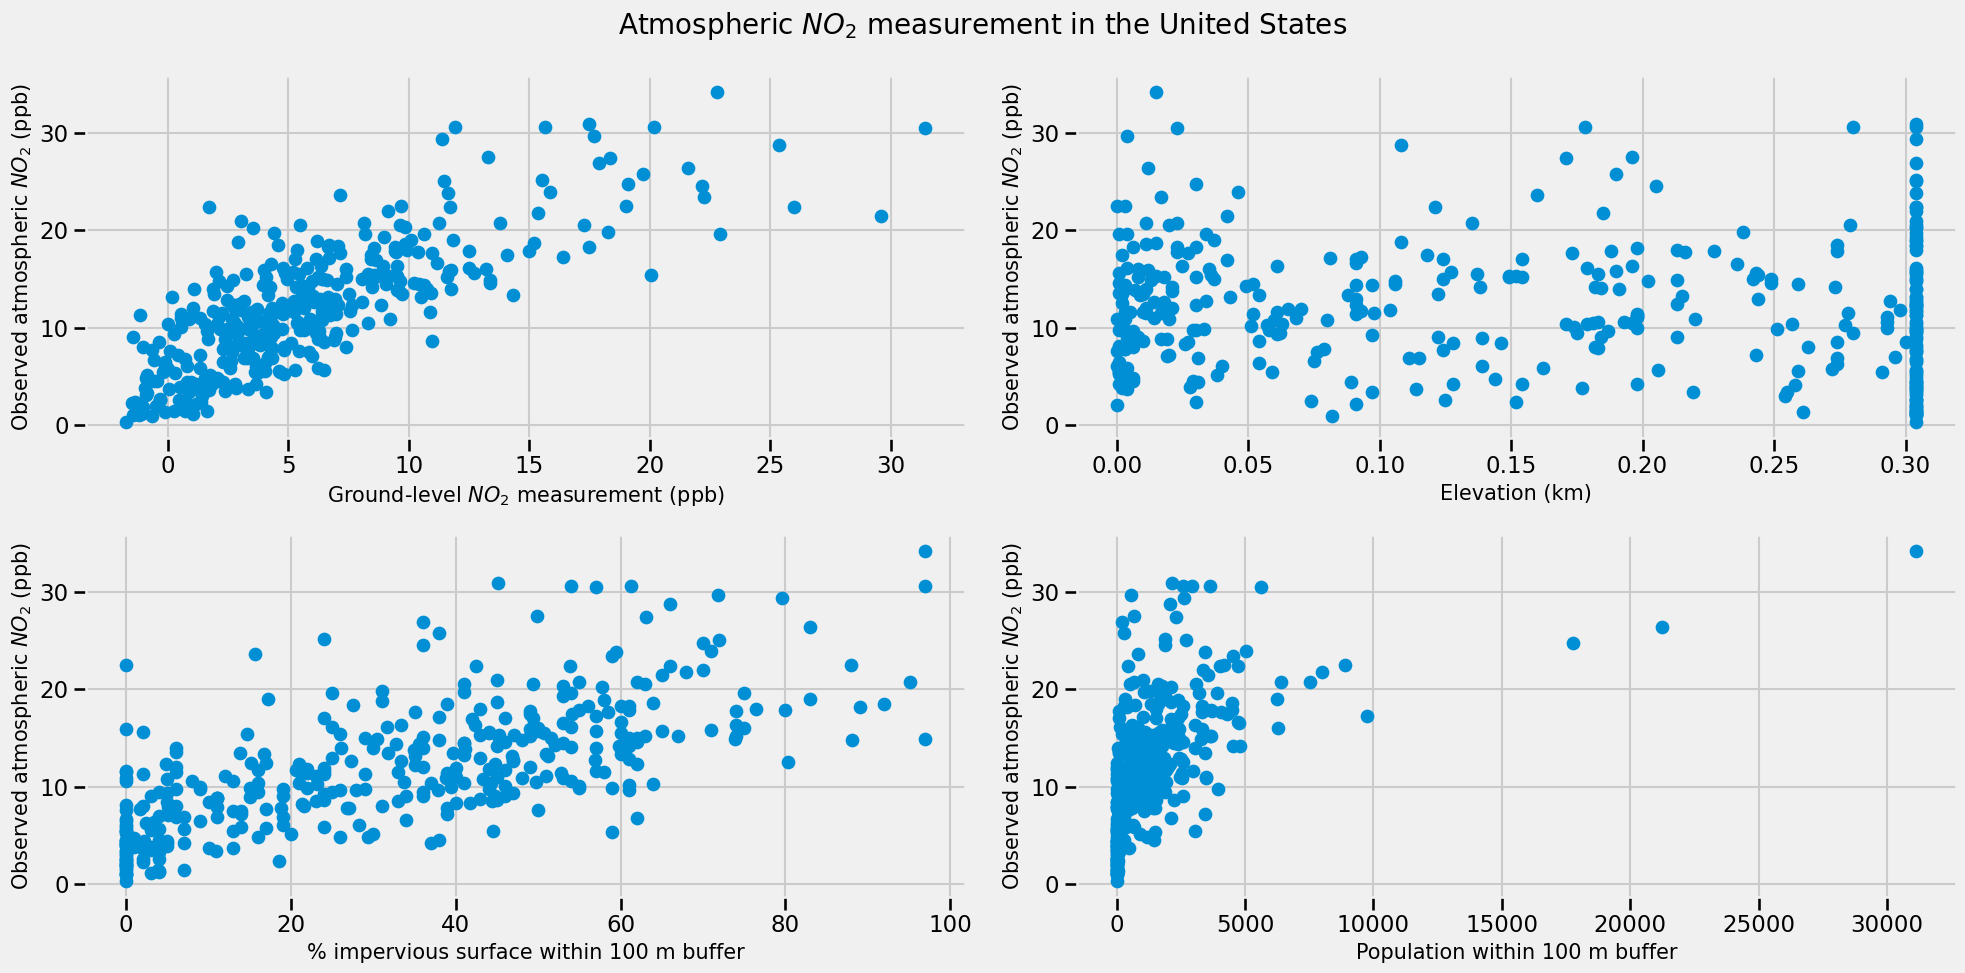

In [10]:
y = df['Observed_NO2_ppb'] # y axis variable
ylab = "Observed atmospheric $NO_2$ (ppb)" # y axis label

msize = 70 # marker size
afsize = 15 # axis font size
tfsize = 20 # title font size

plt.figure(figsize = (20,10))

plt.subplot(221)
plt.scatter(df['WRF+DOMINO'], y, s = msize)
plt.xlabel("Ground-level $NO_2$ measurement (ppb)", fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.subplot(222)
plt.scatter(df['Elevation_truncated_km'], y, s = msize)
plt.xlabel("Elevation (km)", fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.subplot(223)
plt.scatter(df['Impervious_100'], y, s = msize)
plt.xlabel("% impervious surface within 100 m buffer", fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.subplot(224)
plt.scatter(df['Population_100'], y, s = msize)
plt.xlabel("Population within 100 m buffer", fontsize = afsize)
plt.ylabel(ylab, fontsize = afsize)

plt.suptitle("Atmospheric $NO_2$ measurement in the United States", fontsize = tfsize)

plt.subplots_adjust(top=0.5)
plt.tight_layout()

*Your answer here*

**Potential answer**: Some observations from the plot above: Ground level $NO_2$ and % impervious surface within 100 m both seem to have a positive correlation with observed atmospheric $NO_2$. Visually, this trend is clearer than it is with population or elevation. From these plots alone, I would expect a feature selection algorithm to prioritize ground-level $NO_2$ and % impervious surface within 100 m over elevation or population within 100 m, but of course it's hard to say how much predictive power these features have compared to the other 100+ potential features.

### Standardizing your features
As you may recall from lecture, it's a good idea to standardize your independent variables when using regularization methods, especially when the domains of the independent variables span dramatically different ranges.

**Question 1.3 (3pts)** Use the `.describe()` method on the original `df_model` dataframe and examine the results. Provide at least two examples of features whose values span dramatically different ranges (i.e., at least one order of magnitude). Why is it important to standardize your variables? 

In [11]:
# YOUR CODE HERE

*YOUR ANSWER HERE*

In [12]:
# SOLUTION
df_model.describe()

,Observed_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,Impervious_200,Impervious_300,Impervious_400,Impervious_500,Impervious_600,Impervious_700,Impervious_800,Impervious_1000,Impervious_1200,Impervious_1500,Impervious_1800,Impervious_2000,Impervious_2500,Impervious_3000,Impervious_3500,Impervious_4000,Impervious_5000,Impervious_6000,Impervious_7000,Impervious_8000,Impervious_10000,Population_100,Population_200,Population_300,Population_400,Population_500,Population_600,Population_700,Population_800,Population_1000,Population_1200,Population_1500,Population_1800,Population_2000,Population_2500,Population_3000,Population_3500,Population_4000,Population_5000,Population_6000,Population_7000,Population_8000,Population_10000,Major_100,Major_200,Major_300,Major_400,Major_500,Major_600,Major_700,Major_800,Major_1000,Major_1200,Major_1500,Major_1800,Major_2000,Major_2500,Major_3000,Major_3500,Major_4000,Major_5000,Major_6000,Major_7000,Major_8000,Major_10000,Resident_100,Resident_200,Resident_300,Resident_400,Resident_500,Resident_600,Resident_700,Resident_800,Resident_1000,Resident_1200,Resident_1500,Resident_1800,Resident_2000,Resident_2500,Resident_3000,Resident_3500,Resident_4000,Resident_5000,Resident_6000,Resident_7000,Resident_8000,Resident_10000,Resident_10500,Resident_11000,Resident_11500,Resident_12000,Resident_12500,Resident_13000,Resident_13500,Resident_14000,total_100,total_200,total_300,total_400,total_500,total_600,total_700,total_800,total_1000,total_1200,total_1500,total_1800,total_2000,total_2500,total_3000,total_3500,total_4000,total_5000,total_6000,total_7000,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.00000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000
mean,11.932308,5.870935,427.049864,0.155911,32.597564,32.587949,32.634152,32.663021,32.626588,32.580371,32.525231,32.460650,32.317949,32.156400,31.850225,31.487055,31.217791,30.496367,29.764125,29.056108,28.376363,27.090163,25.867014,24.779351,23.811889,22.136649,1433.821758,1430.463334,1423.707308,1414.852356,1411.272648,1411.609964,1409.734140,1407.673473,1403.852957,1402.107178,1399.497844,1390.817350,1384.556010,1368.099336,1344.364651,1315.577142,1289.202733,1236.102609,1178.340862,1128.923773,1077.398729,985.579170,0.033475,0.162976,0.377144,0.655965,1.000206,1.442346,1.970429,2.591989,4.023899,5.739974,8.793957,12.248378,14.802406,21.907391,30.185111,39.77327,50.525211,74.586284,101.699512,132.003409,165.737663,238.635357,0.168606,0.677750,1.540861,2.730538,4.283771,6.189923,8.429514,10.974601,16.

*Example solution:* *One of the key independent variables is the WRF+DOMINO satellite measurement. The measurements range from ~-1.72 PPB (probably an error) to 31.44PPB. Meanwhile, Population features have maxes in the tens of thousands.*

*When variables have different scales, the coefficients assigned by the regularization algorithms to these variables can be influenced by the scale of the data. Variables with larger scales might dominate the regularization penalty, while smaller-scale variables may have their importance understated. Standardization removes this issue and allows for a fair comparison of the importance of different features.*

Luckily for us, `sklearn` has built a built-in method, `StandardScaler` that makes it easy to standardize our variables before we fit our regression models. You can read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html ). In essence, `StandardScaler` takes in our array of features. For each feature (i.e., column), the difference between each element and the mean value of the feature is divided by the standard devation of the features, according to the following equation:

$$
X_{stnd} = \frac{X - \mu}{\sigma}
$$

where $\mu$ and $\sigma$ are the mean and standard deviation, respectively, of the feature $X$. 

[Side note: Strictly speaking, we should only use `StandardScaler` if our features are normally distributed. If that's not the case, `sklearn` offers other scaling methods. For further reading, [see this article](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 ).]

The following code block shows an example of how to use `StandardScaler` to standardize the first three features from the Novotny et. al data.

In [13]:
from sklearn.preprocessing import StandardScaler

novotny_3 = df_model.iloc[:,1:4] # We'll standardize the WRF+DOMINO, Distance_to_coast_km, and Elevation_truncated_km features

scaler = StandardScaler() # Initialize the StandardScaler
scaler.fit(novotny_3) # Fit the standard scaler for each feature
print(scaler.mean_) # Print the mean value of each feature

novotny_stnd = scaler.transform(novotny_3) # Standardize each features
novotny_stnd

[5.87093469e+00 4.27049864e+02 1.55910569e-01]


array([[ 1.05238647, -0.21374302,  1.23996121],
       [ 1.02627128, -0.19350253,  1.23996121],
       [ 0.57149871, -0.22236397,  1.23996121],
       ...,
       [-1.34649959,  2.10266807,  1.23996121],
       [-1.39026179,  2.05431579,  1.23996121],
       [-1.17838759,  2.07830452,  1.23996121]])

In the next section, we'll use `StandardScalar` to transform our features before creating models.

---

Now that we've loaded the data and done some visual exploration, we can think about how to choose which features to include in the model. Features can provide important information and predictive power. However, as we add more features to the model, we risk increasing its variance (meaning our model performs poorly with test data relative to training data). It also can be harder to make sense of a model with lots of features. Rather than throwing out features entirely, we can turn to a technique called regularization to reduce the variance of our model while still incorporating as much information about the data as possible.

More generally, we can adopt the framework of regularized loss minimization.

$$ \large \hat{\theta} = \arg \min_\theta \frac{1}{n} \sum_{i=1}^n \textbf{Loss}\left(y_i, \hat{y_i}\right) + \lambda \textbf{R}(\theta) $$

The regularization term $\textbf{R}(\theta)$ is essentially a penalty for complex and therefore higher variance models. The regularization parameter $\lambda$ determines the degree of regularization to apply and is typically determined through cross validation.

The two regularlization methods that we're exploring in this lab (Ridge regression and Lasso regression) use different regularization terms $\textbf{R}(\theta)$.

### Section 2: L2 Regularization with Ridge Regression


Ridge regression (L2 regularization) uses the *penalty* term $\large R_{L^2}(\theta) = \sum_{k=1}^p (\theta_k)^2$, where $p$ is the number of model features.

Note that $\lambda$ is a tunable parameter - as the person creating the model, you can choose to increase or decrease $\lambda$ based on how much you want to penalize the addition of model features. The higher the value of $\lambda$, the more a model is penalized for the addition of features. A large $\lambda$ decreases the model's variance at the cost of increasing its bias.

**Important:** In scikit-learn, the value of $\lambda$ is passed in through the argument `alpha`.

**Question 2.1 (1pt)** Separate the `df_model` dataframe into train and test sets, with 25% of the data in the test set. Set a `random_state` of 1. Begin by setting `X` to the matrix of predictor variables (all quantitative columns in the dataframe except the response variable) and set `y` equal to the response variable `Observed_NO2_ppb`. Standardize your `X` variables using `StandardScalar`. Then apply `train_test_split` to `X` and `y` to split the data.

In [14]:
# YOUR CODE IN THIS CELL
from sklearn.model_selection import train_test_split

X = df_model.drop(["Observed_NO2_ppb"], axis=1)

# Standardize the features
scaler = StandardScaler()
scaler.fit(...)
X_stnd = scaler.transform(...)

y = ...

X_train, X_test, y_train, y_test = (...)

TypeError: float() argument must be a string or a number, not 'ellipsis'

In [16]:
# solution
from sklearn.model_selection import train_test_split

X = df_model.drop(["Observed_NO2_ppb"], axis=1)

scaler = StandardScaler()
scaler.fit(X)
X_stnd = scaler.transform(X)

y = df_model["Observed_NO2_ppb"]

X_train, X_test, y_train, y_test = train_test_split(X_stnd, y, test_size=0.25, random_state = 1)

In [17]:
#run this to make sure you split the data correctly
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(276, 129) (276,) (93, 129) (93,)


**Question 2.2 (1pt)** Fit a `LinearRegression` model (without regularization) and print the resulting list of coefficients.

In [18]:
# YOUR CODE IN THIS CELL
from sklearn.linear_model import LinearRegression

lm = ...
lm.fit(...)
lm_coefficients = ...

print(lm_coefficients)

AttributeError: 'ellipsis' object has no attribute 'fit'

In [19]:
# SOLUTION
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)
lm_coefficients = lm.coef_

print(lm_coefficients)

[ 4.08399569e+00 -4.29333225e-01  1.19757265e+00  1.37866616e+01
 -2.28343608e+01  1.98803767e+01 -7.56783088e+00 -3.44216850e+01
  6.14198384e+01 -3.98071061e+01  2.93575365e+01 -5.94204368e+01
  7.26888782e+01 -6.80868842e+01  7.78964706e+01 -4.62547715e+01
 -9.06045803e+00  6.14565751e+01 -9.82922956e+01  7.66815419e+01
 -4.75754440e+01  1.00928919e+01  4.17413657e+01 -2.83619161e+01
 -2.69384858e+00  1.74502456e+00 -1.75305761e+00  1.05567278e+01
 -8.37476249e+01  1.75063753e+02 -1.67708601e+02  1.25967557e+02
 -1.38275799e+02  1.39233371e+02 -9.46423278e+01  8.86812782e+01
 -5.96519803e+01 -2.06176813e+01  6.54499633e+01 -6.97973278e+01
  5.19981024e+01 -2.19318917e+01 -2.49517980e+01  4.24224657e+01
 -2.67171973e+01  1.30155664e+01 -2.88339311e+00 -3.17017331e-01
  1.08591088e+00 -1.91876641e+00  2.96341016e+00 -6.62378253e-01
 -6.55290286e+00  7.86569782e+00 -2.11255719e+00 -4.65481807e-01
 -4.50258303e-02  4.77587506e+00 -6.87127820e+00  3.15128556e+00
 -4.13953641e+00  7.11646

**Question 2.3 (1pt)** Import and create a Ridge regression model with `alpha` value set to 1. Fit the training data into the model, then return a list of the coefficients that the model associates wtih each feature in the training data. The [scikit-learn documentation for Ridge()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) is helpful here.

In [20]:
# YOUR CODE IN THIS CELL
from sklearn.linear_model import Ridge

ridge = ...
ridge.fit(...)
ridge_coefficients = ...

print(ridge_coefficients)

AttributeError: 'ellipsis' object has no attribute 'fit'

In [21]:
# solution
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1) #create a Ridge regression object
ridge.fit(X_train, y_train)
ridge_coefficients = ridge.coef_

print(ridge_coefficients)

[ 3.88312122 -0.70899901  1.32404701  1.114356   -0.24711508 -0.42546788
 -0.4930711  -0.50538863 -0.22553371 -0.25129334 -0.27498983 -0.23384815
  0.25612912  0.64172744  1.20851892  1.14039911  0.74687896  0.52371892
  0.12873193  0.144452   -0.37155423  0.03024304  0.30052962 -0.01332597
 -0.69413596 -1.44156763 -0.95524571 -0.70706498 -0.43024479 -0.08044789
 -0.05924927  0.091687    0.40802311  1.70154401  2.02788293  1.5717722
  0.62309228  0.03972778 -0.75277132 -0.59575544 -0.77768221 -1.15566575
 -0.65585043  0.33412245 -0.12151604  0.19863116  0.88804246 -0.16500304
  0.41688719 -0.23097705 -0.07432472  0.99749746 -2.64119139  2.44105673
  0.37192409 -0.93315859  0.28238393  2.44530479 -2.18926894 -0.38167606
 -0.873858    2.56351723 -1.60595349 -1.33681625  1.56696886 -0.2727019
  1.94165242 -1.27054137  0.64071217  0.25716999  0.15570998  0.5032852
 -1.48460535  0.67307585  0.04227193 -0.02642826  0.85368553 -0.75655864
  0.16796248 -0.80598897  0.37745141  0.07452867  0.66

**Question 2.4 (1pt)** Run the code below to generate a bar chart that shows the coefficient values from simple linear regression in blue, and from ridge regression in red. Then, in the markdown cell below, comment on the results. Can you explain your observations based on your understanding of L2 ridge regression?

*Hint* If you're having a hard time making out some of the coefficients, try re-creating the plot using a log scale. 

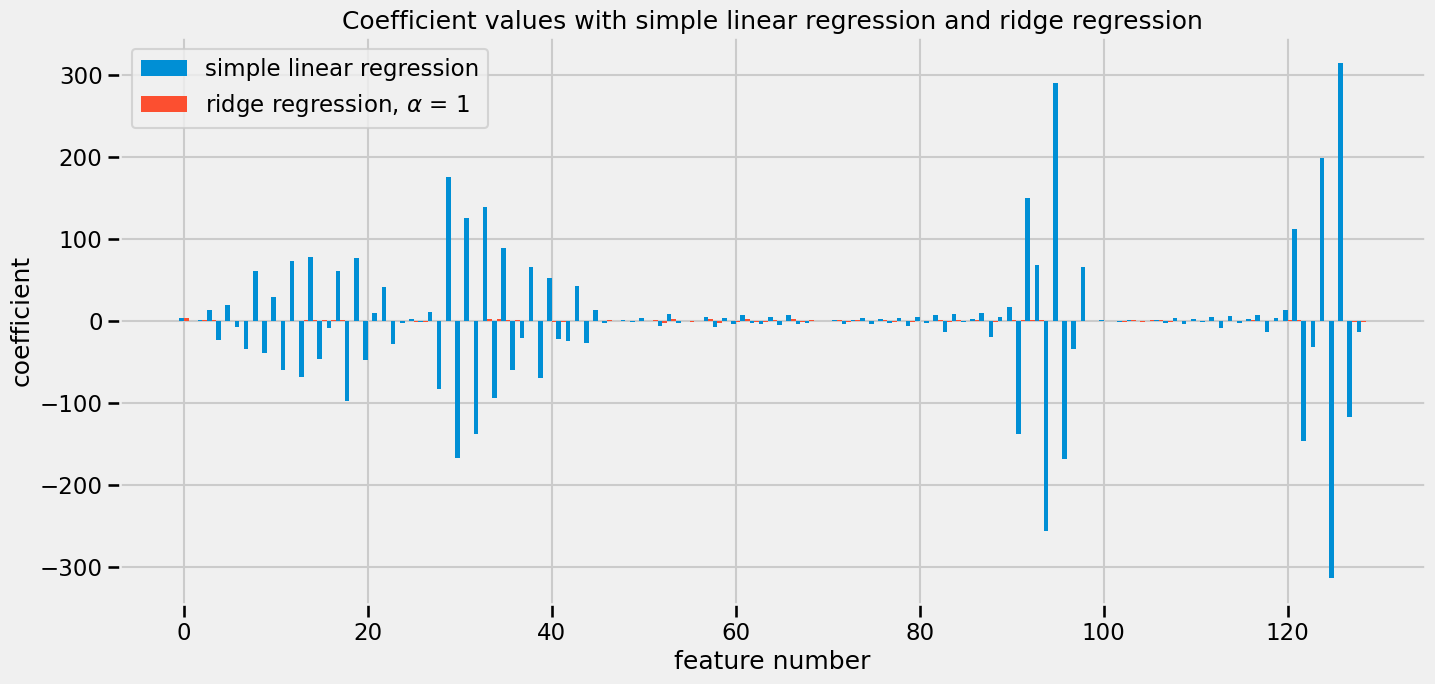

In [22]:
# run this cell
ind = np.arange(len(lm_coefficients))
width = 0.5

plt.figure(figsize = (15,7))

plt.bar(ind-(width/2), width = width, height = lm_coefficients, label = "simple linear regression")
plt.bar(ind+(width/2), width = width, height = ridge_coefficients, label = r"ridge regression, $\alpha$ = 1")
plt.xlabel("feature number")
plt.ylabel("coefficient")
plt.title("Coefficient values with simple linear regression and ridge regression")
plt.legend()
plt.show()

*Your answer here*

*SOLUTION:* We can see the Ridge is indeed forcing the coefficients closer to zero, relative to linear regression.

**Question 2.5 (1pt)**: We just observed how the Ridge Regression model generates coefficients when `alpha` is set to one. Complete the following code which generalizes the fitting and predicting process we just did in Question 2.3 for various values of `alpha`.

Then, calculate the mean squared error (MSE) between our predictions and the test dataset. The MSE in this case is a measure of the accuracy of our predictions.

In [23]:
# Replace ellipses with your code
from sklearn.metrics import mean_squared_error
alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
mses = []

for a in alphas:
    model = ...
    model.fit(...)
    y_pred = model.predict(...)
    mses.append(mean_squared_error(...))

print(mses)


# Create a plot
a_log = np.log10(alphas)

plt.figure(figsize = (15,5))
sns.barplot(a_log, mses, color = 'cadetblue')
plt.xlabel(r'$log_{10}(\alpha)$')
plt.ylabel('MSE')
plt.title('Ridge regression MSE for each value of alpha');

AttributeError: 'ellipsis' object has no attribute 'fit'

[11.983604522600945, 10.502251862993607, 9.92925653193363, 9.584990763967541, 10.412063276976046, 14.44846023864797, 19.979343104684684, 36.3015125624063, 43.91630926800665, 44.93257410687717, 45.03752695381413, 45.0480565046562]


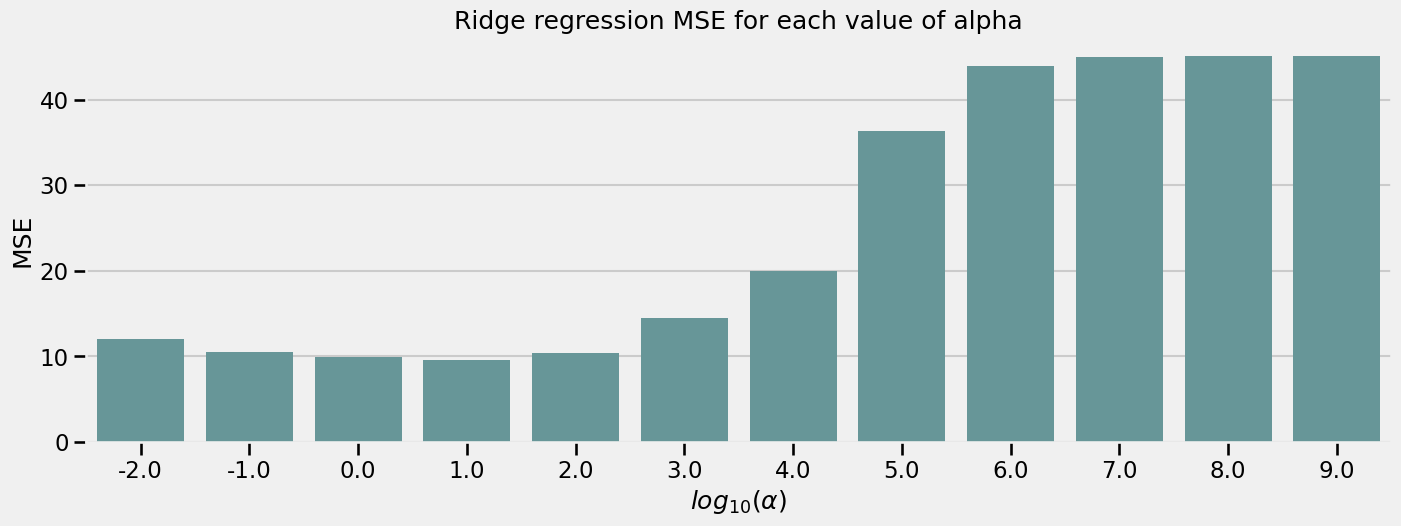

In [24]:
from sklearn.metrics import mean_squared_error
alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
mses = []

for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mses.append(mean_squared_error(y_pred, y_test))

print(mses)

a_log = np.log10(alphas)
plt.figure(figsize = (15,5))
sns.barplot(a_log, mses, color = 'cadetblue')
plt.xlabel(r'$log_{10}(\alpha)$')
plt.ylabel('MSE')
plt.title('Ridge regression MSE for each value of alpha');

**Question 2.6 (2 pts)** What is the lowest MSE observed and which value of alpha did it come from? What value of $\lambda$ does that correspond to? Does the value of $\lambda$ that minimizes MSE more heavily or less heavily penalize additional coefficients than our initial value of $\lambda$ that we used to produce the plot in Question 2.4?

In [25]:
print("lowest MSE:", np.min(mses), "; alpha:", alphas[np.argmin(mses)]) #"; lambda:", 1/alphas[np.argmin(mses)])

lowest MSE: 9.584990763967541 ; alpha: 10.0


YOUR ANSWER HERE

### Section 3: L1 Regularization with Lasso Regression

While ridge regression minimizes coefficients, it incorporates *all* the features into your model. It won't actually drive any coefficients to 0 (unless $\lambda$ = $\infty$!). This can make your model less *interpretable* - for instance, in the case of the model we created in Section 2, we have over 120 non-zero coefficients and thus over 120 features.

Lasso regression (also called L1 Regularization) avoids the issue of including too many unimportant variables by using a model formulation that can drive some coefficients to 0.

Lasso regression uses the *penalty* term $\large R_{L^1}(\theta) = \sum_{k=1}^p \Big|\theta_k\Big|$, where $p$ is the number of model features.

**Question 3.1 (1pt)** Let's repeat the steps we did above for Ridge Regression, this time for Lasso Regression. Create a Lasso model with an `alpha` of 1 and fit on the X_train and y_train dataset.

In [26]:
# YOUR CODE IN THIS CELL
from sklearn.linear_model import Lasso

lasso = ...
lasso.fit(...)
lasso_coefficients = ...
print(lasso_coefficients)

AttributeError: 'ellipsis' object has no attribute 'fit'

In [27]:
# SOLUTION
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_coefficients = lasso.coef_
print(lasso_coefficients)

[ 2.91473792 -0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.67775051  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.01915487
  0.          0.          0.33495264  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.16374227  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

Run the cell below to output a plot that shows the coefficients from the simple linear regression in part 2, the ridge regression in part 2, and the lasso regression above side-by-side. The coefficients are plotted on a logarithmic scale. You can adapt the code from question 2.4 or write your own.

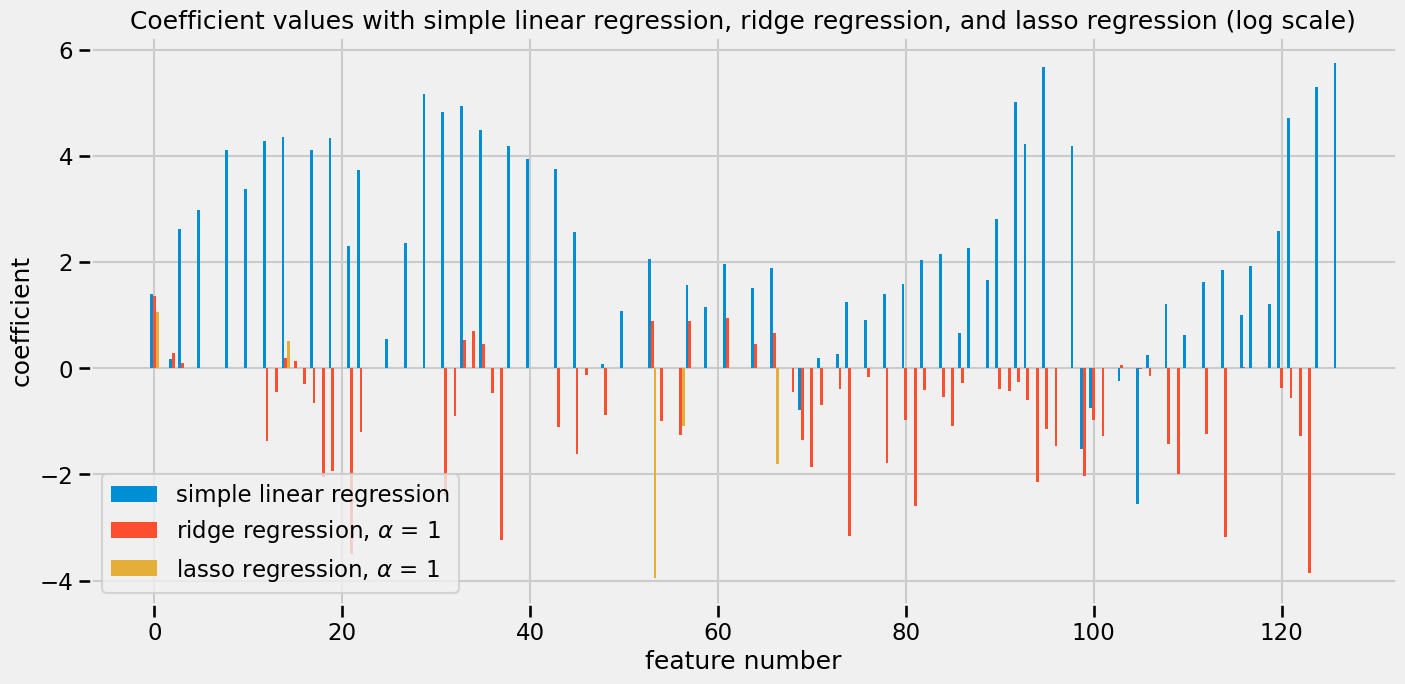

In [28]:
# run this cell
ind = np.arange(len(lm_coefficients))
width = 0.3

plt.figure(figsize = (15,7))

plt.bar(ind-width, width = width, height = np.log(lm_coefficients), label = "simple linear regression")
plt.bar(ind, width = width, height = np.log(ridge_coefficients), label = r"ridge regression, $\alpha$ = 1")
plt.bar(ind+width, width = width, height = np.log(lasso_coefficients), label = r"lasso regression, $\alpha$ = 1")
plt.xlabel("feature number")
plt.ylabel("coefficient")
plt.title("Coefficient values with simple linear regression, ridge regression, and lasso regression (log scale)")
plt.legend()
plt.show()

**Question 3.2 (1pt):** Comment on the results in the graph above. Can you explain your observations based on your understanding of L1 lasso regression?

*Your answer here*

**Question 3.3 (2pts)** What proportion of the datasets features are "ignored" by this lasso model? What are the column names of the features that are **not** ignored by this lasso model?

In [29]:
prop_ignored = 1 - (np.count_nonzero(lasso_coefficients) / len(lasso_coefficients))
print("proportion of features ignored:", prop_ignored)

cols_included = X.columns[lasso_coefficients != 0]
print("columns included:", cols_included)

proportion of features ignored: 0.9612403100775194
columns included: Index(['WRF+DOMINO', 'Impervious_1800', 'Major_700', 'Major_1200',
       'Major_7000'],
      dtype='object')


YOUR ANSWER HERE

*Solution*

*proportion of features ignored: 0.9612403100775194
columns included: Index(['WRF+DOMINO', 'Impervious_1800', 'Major_700', 'Major_1200',
       'Major_7000'],
      dtype='object')*

**Question 3.4 (1pt)**: Look back to the features you plotted in Question 1.2. Were any of those features ignored or included by the lasso model?

YOUR ANSWER HERE

**Question 3.5 (2pts)**: Remember how we calculated the test MSE for different values of $\alpha$ in question 2.5? Now, we're going to write a function that automates that process, taking as input a list of alphas `alphas` and a model (`Ridge` or `Lasso`). Complete the function below, and then define a list of alphas and call the function using the `Lasso` model to return a list of MSEs.

In [30]:
def calculate_mses(alphas, Model):
    """
    Input:
        alphas (array): contains floats of various alpha values
        Model (sklearn model): the type of sklearn model on which to fit the data
    Output:
        an array of floats containing the mean-squared-errors from the predictions
    """
    mses = []

    for a in alphas:
        model = ... # Your code here
        model.fit(...)
        y_pred = ...
        mses.append(...)
    return mses

In [31]:
alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
lasso_mses = calculate_mses(alphas, Lasso)
lasso_mses

AttributeError: 'ellipsis' object has no attribute 'fit'

In [32]:
def calculate_mses(alphas, Model):
    """
    Input:
        alphas (array): contains floats of various alpha values
        Model (sklearn model): the type of sklearn model on which to fit the data
    Output:
        an array of floats containing the mean-squared-errors from the predictions
    """
    mses = []

    for a in alphas:
        model = Model(alpha=a)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mses.append(mean_squared_error(y_pred, y_test))
        
    return mses

In [33]:
alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
lasso_mses = calculate_mses(alphas, Lasso)
lasso_mses

[9.707514985344897,
 9.089355234233018,
 12.585345986137007,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956,
 45.049226840488956]

**Question 3.6 (1pt)** How do the best Ridge regression model (identified in Question 2.6) and the best Lasso regression model (based on your answer to Question 3.5) perform relative to simple linear regression with respect to the mean squared error? Which model has the lowest error?

In [34]:
print("linear model MSE:", mean_squared_error(lm.predict(X_test), y_test))
print("ridge regression minimum MSE:", np.min(mses))
print("lasso regression minimum MSE:", np.min(lasso_mses))

linear model MSE: 18.15692978464812
ridge regression minimum MSE: 9.584990763967541
lasso regression minimum MSE: 9.089355234233018


*YOUR ANSWER HERE*

# Hooray, you're done! 

Please remember to submit your lab work, after clicking Kernel -> Restart & Run All, in .pdf and .ipynb format on bCourses.

Further Reading:

Regularization - https://www.textbook.ds100.org/ch/16/reg_intro.html
    
Notebook developed by Alex McMurry, Kevin Marroquin, and Melissa Ly

Data Science Modules: http://data.berkeley.edu/education/modules